In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'NanumGothicCoding'
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
import missingno as msno

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
model_data = pd.read_csv('./data/model_data.csv')
model_data
# year_date	: 날짜, avgTemp : 평균온도, rainFall : 강수량, avgWind : 평균 풍속, sumSunshine : 합계일사량, avgPriceGreen/Red : 청상추가격 , 적상추

year_date  avgTemp  rainFall  avgWind  sumSunshine  avgPriceRed  \
0     20190701     23.9       0.0      2.3        20.33        20000   
1     20190702     24.4       0.0      2.3        21.13        17000   
2     20190703     24.1       0.0      1.7        12.62        20000   
3     20190704     25.4       0.0      1.9        27.41        22000   
4     20190705     27.6       0.0      1.5        24.78        22000   
..         ...      ...       ...      ...          ...          ...   
725   20210625     24.1       0.0      2.0        24.74        21600   
726   20210626     22.8       4.5      1.8        14.24        21600   
727   20210627     24.5      38.2      2.0        22.48        21600   
728   20210628     23.7       0.1      1.9        13.52        21300   
729   20210629     23.9       8.0      1.8        14.10        18600   

     avgPriceGreen  
0            48980  
1            48980  
2            48980  
3            48980  
4            48980  
..             ...  
725          26000  
726          26000  
727          26000  
728          23300  
729          21600  

[730 rows x 7 columns]

In [3]:
model_data.info()
model_data['avgTemp'] = model_data['avgTemp'].astype(np.float32)
model_data['rainFall'] = model_data['rainFall'].astype(np.float32)
model_data['avgWind'] = model_data['avgWind'].astype(np.float32)
model_data['sumSunshine'] = model_data['sumSunshine'].astype(np.float32)
#model_data['avgPriceRed'] = model_data['avgPriceRed'].astype(np.float32)
model_data['avgPriceGreen'] = model_data['avgPriceGreen'].astype(np.float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_date      730 non-null    int64  
 1   avgTemp        730 non-null    float64
 2   rainFall       730 non-null    float64
 3   avgWind        730 non-null    float64
 4   sumSunshine    727 non-null    float64
 5   avgPriceRed    730 non-null    int64  
 6   avgPriceGreen  730 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 40.0 KB


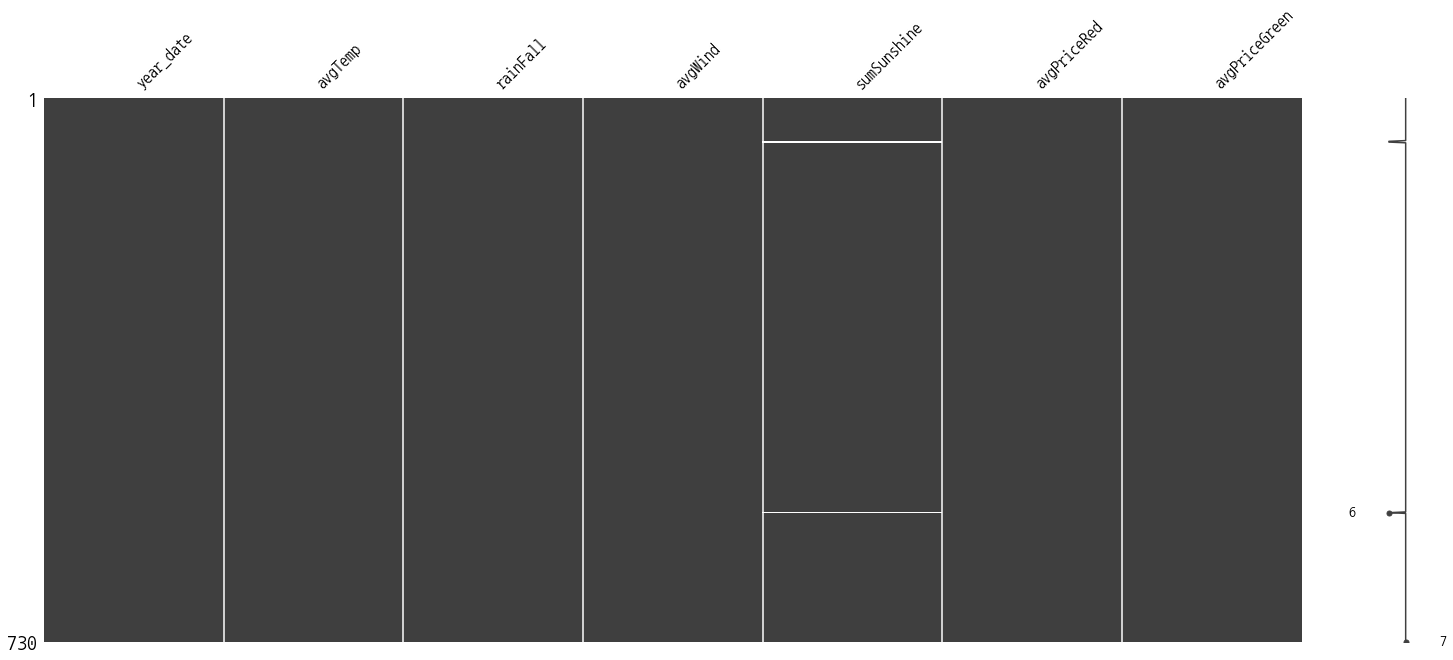

In [4]:
# 합계일사량이 조사가 되지 않은 기상청정보가 존재 => 제거한다.
msno.matrix(model_data)
finish_data = model_data.dropna()

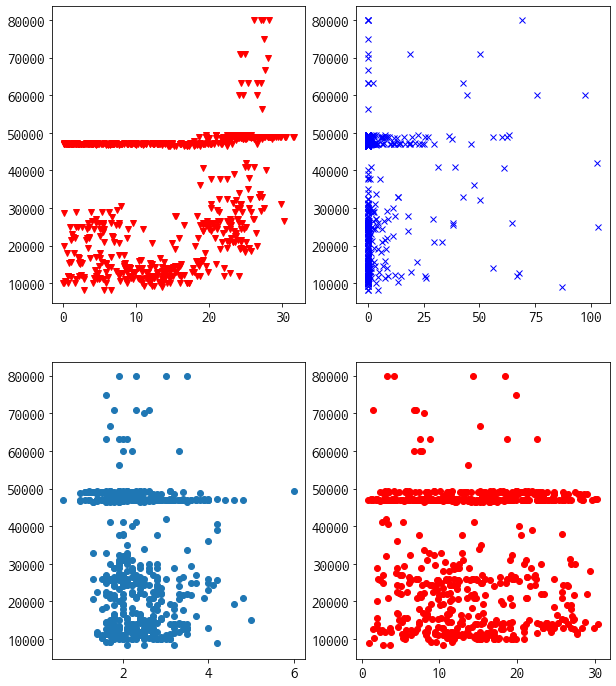

In [5]:
# 시각화 => 평균기온별 가격 // 강수량별 가격 // 평균풍속별 가격 // 일사량별 가격
fig = plt.figure(figsize=[10,12])
axes1 = fig.add_subplot(2,2,1)
axes2 = fig.add_subplot(2,2,2)
axes3 = fig.add_subplot(2,2,3)
axes4 = fig.add_subplot(2,2,4)
axes1.plot(finish_data['avgTemp'],finish_data['avgPriceGreen'],'vr')
axes2.plot(finish_data['rainFall'],finish_data['avgPriceGreen'],'xb')
axes3.plot(finish_data['avgWind'],finish_data['avgPriceGreen'],'o')
axes4.plot(finish_data['sumSunshine'],finish_data['avgPriceGreen'],'or')
# 보았을때 강수량과는 거의 상관관계가 없다고 보여진다.

In [6]:
# 데이터프레임에서 사용된 데이터 넘파이 배열로 만든다.
np_data = np.array(finish_data,dtype=np.float32)
x_data = np_data[:,1:5]
y_data = np_data[:,6:7]

# 변수 선언
X = tf.placeholder(dtype=tf.float32, shape=[None,4]) # 변화요인  이 들어갈 변수
Y = tf.placeholder(dtype=tf.float32, shape=[None,1]) # 실제값     이 들어갈 변수
a = tf.Variable(tf.random_uniform([4,1]), dtype=tf.float32) # 가중치(기울기)
b = tf.Variable(tf.random_uniform([1]), dtype=tf.float32)   # 바이어스(y절편)
y = tf.matmul(X,a) + b # 예측값

In [7]:
# 오차 함수를 만든다. => 예측값(y)과 실제값(Y)의 편차의 제곱에 대한 평균 => 평균제곱법
loss = tf.reduce_mean(tf.square(y - Y))
# 경사하강법 알고리즘을 사용해서 오차 함수의 결과를 최소로 하는 식을 찾는다.
gradient_decent = tf.train.GradientDescentOptimizer(0.00005).minimize(loss)

In [9]:
# 학습시킨다.
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# 920000에포크에서 더이상 손실이 줄어들지 않아 종료
for i in range(1000001) :
    loss_, y_, _ = sess.run([loss,y,gradient_decent],feed_dict={X:x_data,Y:y_data})
    
    if i % 10000 == 0:
        print('epoch : {}, loss : {} , 실제값 : {}'.format(i,loss_,y_[0]))
        
# 920000에포크에서 더이상 손실이 줄어들지 않아 종료
# =========== 학습 완료


saver = tf.train.Saver()
save_path = saver.save(sess, './project_data/green/green_saved.cpkt')
print('학습된 모델을 저장했습니다.')

epoch : 0, loss : 1457722240.0 , 실제값 : [44.739773]
epoch : 10000, loss : 301289632.0 , 실제값 : [41968.055]
epoch : 20000, loss : 289740576.0 , 실제값 : [41090.414]
epoch : 30000, loss : 284381760.0 , 실제값 : [40728.098]
epoch : 40000, loss : 279910336.0 , 실제값 : [40510.62]
epoch : 50000, loss : 275900352.0 , 실제값 : [40338.156]
epoch : 60000, loss : 272282688.0 , 실제값 : [40183.29]
epoch : 70000, loss : 269016160.0 , 실제값 : [40038.746]
epoch : 80000, loss : 266067776.0 , 실제값 : [39902.043]
epoch : 90000, loss : 263405552.0 , 실제값 : [39772.33]
epoch : 100000, loss : 261002736.0 , 실제값 : [39649.227]
epoch : 110000, loss : 258833216.0 , 실제값 : [39532.22]
epoch : 120000, loss : 256873920.0 , 실제값 : [39420.92]
epoch : 130000, loss : 255106928.0 , 실제값 : [39315.45]
epoch : 140000, loss : 253510448.0 , 실제값 : [39215.004]
epoch : 150000, loss : 252068896.0 , 실제값 : [39119.6]
epoch : 160000, loss : 250767936.0 , 실제값 : [39028.938]
epoch : 170000, loss : 249594016.0 , 실제값 : [38942.87]
epoch : 180000, loss : 248534416